# setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
print("TF version: ", tf.__version__)
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")    

from tensorflow.python.keras.utils.data_utils import Sequence

sklearn version:  1.0.2
TF version:  2.7.0
GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


# Get the data

In [2]:
#작성자 전민재
import csv
def load_Emist(exsitNumpy=False, needTranspose=True):
    if (exsitNumpy == False):
        #"./emnist-byclass-test.csv"
        #train-set
        #"공용/datasets/Emnist/" 위치에 csv 저장 
        csv_train_data_file = open("../공용/datasets/Emnist/train_data.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        csv_train_label_file = open("../공용/datasets/Emnist/train_label.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
    
        
        f_train = csv.reader(csv_train_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        l_train=csv.reader(csv_train_label_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        #valid-set
    
        csv_valid_data_file = open("../공용/datasets/Emnist/valid_data.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        csv_valid_label_file = open("../공용/datasets/Emnist/valid_label.csv", "r", encoding="ms932", errors="", newline="" ) #리스트 형식 
        
        f_valid = csv.reader(csv_valid_data_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        l_valid = csv.reader(csv_valid_label_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)
        X_train=[]
        y_train=[]
        X_valid=[]
        y_valid=[]
        for i, row in enumerate(f_train):
            #행마다 int로 형변환
            for idx, char in enumerate(row):
                row[idx]=int(char)
            #train
            #data 추가    
            X_train.append(row)
            
        for i, row in enumerate(f_valid):
            #행마다 int로 형변환
            for idx, char in enumerate(row):
                row[idx]=int(char)
            #valid
            #data 추가    
            X_valid.append(row)


        for i, row in enumerate(l_train):

            #train
            #label 추가
            y_train.append(int(row[0]))
            
        for i, row in enumerate(l_valid):

            #valid
            #label 추가
            y_valid.append(int(row[0]))
            
            
        

        #train
        X_train=np.array(X_train)
        X_train=X_train.reshape(-1,28,28)
        #valid
        X_valid=np.array(X_valid)
        X_valid=X_valid.reshape(-1,28,28)
        
        csv_train_data_file.close()
        csv_train_label_file.close()
        csv_valid_data_file.close()
        csv_valid_label_file.close()
        
        #kaggle dataset이 시계반대방향으로 90도 회전 되있고 상하 반전 되어있음
        def rotate_90(m):
            N = len(m)
            ret = [[0] * N for _ in range(N)]

            for r in range(N):
                for c in range(N):
                    ret[c][N-1-r] = m[r][c]
            return np.array(ret)

        def vreflect(m):
            N = len(m)
            ret = [[0] * N for _ in range(N)]

            for r in range(N):
                for c in range(N):
                    ret[r][c] = m[r][N-1-c]
            return np.array(ret)
        
        if needTranspose == True:
            #train
            #회전
            for idx,i in enumerate(X_train):
                X_train[idx]=rotate_90(i)
            #상하반전
            for idx,i in enumerate(X_train):
                X_train[idx]=vreflect(i)

            #valid
            #회전
            for idx,i in enumerate(X_valid):
                X_valid[idx]=rotate_90(i)
            #상하반전
            for idx,i in enumerate(X_valid):
                X_valid[idx]=vreflect(i)

       
        
        
        #저장용
        #train
        #(533917,28,28)
        np.save('../공용/X_train',X_train)
        np.save('../공용/y_train',y_train)
        #valid
        np.save('../공용/X_valid',X_valid)
        np.save('../공용/y_valid',y_valid)
        
   
    X_train=np.load('../공용/X_train.npy')
    y_train=np.load('../공용/y_train.npy')
    X_valid=np.load('../공용/X_valid.npy')
    y_valid=np.load('../공용/y_valid.npy')
    
    return X_train, y_train, X_valid, y_valid


In [3]:
#황성현
#npy 파일이 존재할 경우 exsitNumpy = True, 업으면 False
X_train, y_train, X_valid, y_valid = load_Emist(exsitNumpy=True)
X_train.shape

(533917, 28, 28)

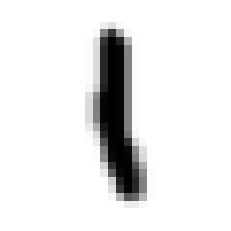

1


In [4]:
import cv2 as cv
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
ids=0
X_new=X_train[ids]
y_new=y_train[ids]
c=X_new.reshape(28,28)


plt.imshow(c, cmap="binary")
plt.axis('off')
plt.show()
print(y_new)

# Prepare the data

In [5]:
#황성현
#data, batch size 성정
train_size=len(X_train)
valid_size=len(X_valid)
batch_size=32


In [6]:
#황성현
X_train=np.reshape(X_train,[-1,784])
X_valid=np.reshape(X_valid,[-1,784])
X_train.shape,X_valid.shape

((533917, 784), (164015, 784))

In [7]:
#황성현
y_train=np.reshape(y_train,[-1,1])
y_valid=np.reshape(y_valid,[-1,1])

y_train.shape,y_valid.shape

((533917, 1), (164015, 1))

In [8]:
#황성현
train_full = np.append(X_train,y_train,axis=1)
valid_full = np.append(X_valid,y_valid,axis=1)
train_full.shape,valid_full.shape

((533917, 785), (164015, 785))

In [9]:
#황성현
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    
    Emnist_dir = os.path.join("../공용/datasets", "Emnist")
    os.makedirs(Emnist_dir, exist_ok=True)
    path_format = os.path.join(Emnist_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        try:
            with open(part_csv, "xt", encoding="utf-8") as f:
                if header is not None:
                    f.write(header)
                    f.write("\n")
                for row_idx in row_indices:
                    f.write(",".join([repr(col) for col in data[row_idx]]))
                    f.write("\n")
        except:
            continue
    return filepaths

In [10]:
#황성현
train_filepaths = save_to_multiple_csv_files(train_full, "train", n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_full, "valid", n_parts=20)

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

def dataaugmentation(X):
    datagen=ImageDataGenerator(rotation_range=40,width_shift_range = 0.2, 
        height_shift_range = 0.2)
    #영어 부분 2배 생성
    #차원변환 
    X=tf.reshape(X,[28,28,1])

    #새로운 데이터 생성
    angle=(random.random()%1)*1.4-0.7
    image_result =tfa.image.rotate(X, tf.constant(angle))#rotate -pi/4 ~ pi/4
    shift=(random.random()%1)*8-4
    image_result=tfa.image.translate(image_result,[tf.constant(shift),tf.constant(shift)])
    
    return image_result

In [27]:
#황성현
n_inputs = X_train.shape[-1]
print("n_inputs =",n_inputs)
@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    x=tf.reshape(x,[28,28,1])
    y = tf.stack(fields[-1:])
    augment_image = x
    if y > 10:
        augment_image = dataaugmentation(x)
        
        
    resized_image = tf.image.resize(augment_image, [224, 224])
    if resized_image.shape[2] == 1:
        temp=tf.concat([resized_image,resized_image],2)
        resized_image=tf.concat([temp,resized_image],2)
    final_image = keras.applications.mobilenet.preprocess_input(resized_image)
    
    return final_image, y

n_inputs = 784


In [28]:
#황성현
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [29]:
#황성현
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths,batch_size=batch_size, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths,batch_size=batch_size, repeat=None)
train_set,valid_set

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 1)), types: (tf.float32, tf.float32)>)

In [5]:
del X_train, y_train, X_valid, y_valid

# SMV2L

In [15]:
#황성현
class Inveted_Residual_Block(keras.layers.Layer):
    def __init__(self,c,s=1,t=1,n=1,**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.layers.ReLU(max_value=6)
        self.main_layers = [
            
            ]
        self.strides_layers=[
           ]
        self.s=s
        self.t=t
        self.c=c
        self.n=n
        
    def build(self,batch_input_shape):
        print(self.name,": batch_input_shape =",batch_input_shape)
        
        self.main_layers = [
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1, 
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=1,padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c,kernel_size=1, strides=1,padding="SAME", activation=self.activation),
            ]
        self.strides_layers=[
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=batch_input_shape[-1]*self.t, kernel_size=1,strides=1,
                                padding="SAME", activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.DepthwiseConv2D(kernel_size=3, strides=self.s,padding="SAME",activation=self.activation),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(filters=self.c, kernel_size=1,strides=1,padding="SAME",activation=self.activation),
        ]

    def call(self, inputs):
        Z = inputs
        
        for n in range(0,self.n):
            if n == 0:
                for layer in self.strides_layers:
                    Z = layer(Z)
            else:
                skip_Z = Z
                for layer in self.main_layers:
                    Z = layer(Z)
                
                Z += skip_Z
    
        return Z
    
    def get_config(self):
        base=super().get_config()
        return{**base,"s":self.s,"t":self.t,"c":self.c,"n":self.n}

In [16]:
#황성현
n_classes=62
smv2_l=keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=[224,224,3]),
    keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
    Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
    Inveted_Residual_Block(t=4,c=16,n=2,s=2,name="IRB2"),
    Inveted_Residual_Block(t=8,c=32,n=2,s=2,name="IRB3"),
    Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
    Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
    Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
    keras.layers.ReLU(max_value=6),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_classes,activation="softmax")
])
smv2_l.summary()

IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 16)
IRB4 : batch_input_shape = (None, 28, 28, 32)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 IRB1 (Inveted_Residual_Bloc  (None, 112, 112, 16)     2288      
 k)                                                              
                                                                 
 IRB2 (Inveted_Residual_Bloc  (None, 56, 

In [17]:
#황성현
smv2_l.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])

In [22]:
smv2_l=keras.models.load_model("smv2l_nadam.h5",custom_objects={"Inveted_Residual_Block":Inveted_Residual_Block})

IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 16)
IRB4 : batch_input_shape = (None, 28, 28, 32)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)


In [23]:
#황성현 
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2L%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2l_nadam.h5",save_best_only=True)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=smv2_l.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=300,callbacks=[tboard_callback, check_cb, earlystop_cb])

Epoch 1/300
16684/16684 [==============================] - 3444s 206ms/step - loss: 0.2187 - accuracy: 0.9204 - val_loss: 0.2166 - val_accuracy: 0.9218
Epoch 2/300
16684/16684 [==============================] - 3429s 206ms/step - loss: 0.2103 - accuracy: 0.9230 - val_loss: 0.2111 - val_accuracy: 0.9244
Epoch 3/300
16684/16684 [==============================] - 3422s 205ms/step - loss: 0.2076 - accuracy: 0.9239 - val_loss: 0.2079 - val_accuracy: 0.9245
Epoch 4/300
16684/16684 [==============================] - 3389s 203ms/step - loss: 0.2048 - accuracy: 0.9248 - val_loss: 11.6709 - val_accuracy: 0.0398
Epoch 5/300
16684/16684 [==============================] - 3384s 203ms/step - loss: 0.2058 - accuracy: 0.9241 - val_loss: 0.5709 - val_accuracy: 0.8201
Epoch 6/300
16684/16684 [==============================] - 3381s 203ms/step - loss: 0.2047 - accuracy: 0.9243 - val_loss: 0.2144 - val_accuracy: 0.9231
Epoch 7/300
16684/16684 [==============================] - 3380s 203ms/step - loss: 0.2

In [31]:
smv2_l_best=keras.models.load_model("smv2l_nadam.h5",custom_objects={"Inveted_Residual_Block":Inveted_Residual_Block})

IRB1 : batch_input_shape = (None, 112, 112, 32)
IRB2 : batch_input_shape = (None, 112, 112, 16)
IRB3 : batch_input_shape = (None, 56, 56, 16)
IRB4 : batch_input_shape = (None, 28, 28, 32)
IRB5 : batch_input_shape = (None, 14, 14, 64)
IRB6 : batch_input_shape = (None, 7, 7, 128)


In [32]:
smv2_l_best.evaluate(valid_set,steps=int(valid_size / batch_size), batch_size=batch_size)

5125/5125 [==============================] - 172s 33ms/step - loss: 5.2497 - accuracy: 0.5150


[5.249746799468994, 0.5150243639945984]

In [ ]:
smv2_l_best.evaluate(train_set,steps=int(train_size / batch_size), batch_size=batch_size)

15302/16684 [==========================>...] - ETA: 48s - loss: 5.2480 - accuracy: 0.5147

# SMV2P

In [ ]:
#황성현
n_classes=62
smv2_p=keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=[224,224,3]),
    keras.layers.Conv2D(filters=32,kernel_size=3,strides=2,padding="same",activation="relu"),
    Inveted_Residual_Block(t=1,c=16,n=1,s=1,name="IRB1"),
    Inveted_Residual_Block(t=4,c=16,n=2,s=2,name="IRB2"),
    Inveted_Residual_Block(t=8,c=32,n=2,s=2,name="IRB3"),
    Inveted_Residual_Block(t=8,c=64,n=2,s=2,name="IRB4"),
    Inveted_Residual_Block(t=8,c=128,n=1,s=2,name="IRB5"),
    Inveted_Residual_Block(t=8,c=1024,n=1,s=1,name="IRB6"),
    keras.layers.ReLU(max_value=6),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_classes,activation="softmax")
])
smv2_p.summary()

In [ ]:
#황성현
smv2_p.compile(loss="sparse_categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])

In [ ]:
#황성현
batch_size=32
from datetime import datetime
logs = "logs/" + datetime.now().strftime("SMV2L%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 profile_batch = '500,520')
check_cb=tf.keras.callbacks.ModelCheckpoint(filepath="smv2l_nadam.h5",save_best_only=True)
earlystop_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history=smv2_p.fit(train_set, batch_size = batch_size,
                    steps_per_epoch=int(train_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(valid_size / batch_size),
                    epochs=300,callbacks=[tboard_callback, check_cb, earlystop_cb])